In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize

def mnk_intercept(X, Y, resolution=10000):
    if isinstance(X, pd.Series): X = X.to_numpy()
    if isinstance(Y, pd.Series): Y = Y.to_numpy()
    
    a = (X@Y)/(X@X)
    min_loss = np.sum((Y - a * X)**2)
    def relative_loss(delta):
        return np.sum((Y - (a + delta) * X)**2) / min_loss
    
    delta = 0
    
    step = a / resolution
    while relative_loss(delta) < 2:
        delta += step
    
    
    def f(x):
        return a * x
    
    return a, delta, f

def mnk(X, Y):
    a, b = np.polyfit(X, Y, deg=1)
    
    S_x = np.std(X) ** 2
    S_y = np.std(Y) ** 2
    da = 2 * np.sqrt((S_y/S_x - a ** 2)/(len(X) - 2))
    db = da * np.sqrt(np.mean(X**2))
    
    def f(x):
        return a*x + b
    
    return a, b, da, db, f

def chi_fit(X, Y, dY, sigma=1, force_intercept=False):
    """
    Does linear regression y = ax + b using least chi square method
    
    returns a, b, da, db
    """
    
    if len(X) != len(Y):
        raise ValueError("dimensons of X and Y don't match")
    
    L = len(X)
    
    if force_intercept:
        def f(a):
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i])) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1,), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_):
            return np.sum(f((a_))**2)

        da = 0
        inc_a = a/10000

        while sigma > chi_2(a+da) - chi_2_min:
            da += inc_a
        
        def linear_f(x):
            return a*x
        
        return a, 0, da, 0, linear_f, chi_2_min
    else:
        def f(coeffs):
            a, b = coeffs
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i] + b)) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1, 1), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, b = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_, b_):
            return np.sum(f((a_, b_))**2)

        da, db = 0, 0
        inc_a = a/10000
        inc_b = b/10000

        while sigma > chi_2(a+da, b) - chi_2_min:
            da += inc_a

        while sigma > chi_2(a, b+db) - chi_2_min:
            db += inc_b
        
        def linear_f(x):
            return a*x + b
        
        return a, b, da, db, linear_f, chi_2_min
        

# Резонансная кривая, АЧХ

f - частота\
U - напряжение\
U_r - $U/U_0$\
f_r - $\nu/\nu_0$

In [13]:
data = pd.read_csv('A_f.csv')
f_0 = 1560 # resonant frequency

f_1 = data['f1'].dropna()
f_1_r = f_1 / f_0
U_1 = data['V1'].dropna()
U_1_0 = U_1.max()
U_1_r = U_1 / U_1_0

f_2 = data['f2'].dropna()
f_2_r = f_2 / f_0
U_2 = data['V2'].dropna()
U_2_0 = U_2.max()
U_2_r = U_2 / U_2_0

dU = 0.04
dU_1_r = U_1_r * np.sqrt((dU/U_1)**2 + (dU/U_1_0)**2)
dU_2_r = U_2_r * np.sqrt((dU/U_2)**2 + (dU/U_2_0)**2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


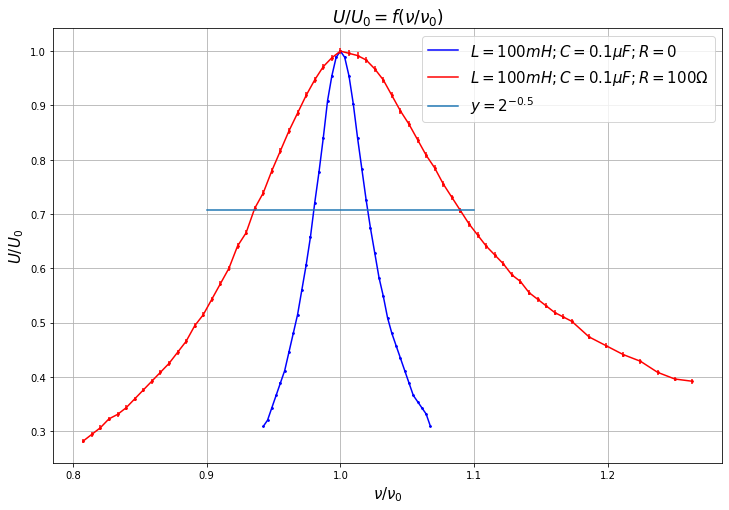

In [14]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$U/U_0 = f(\nu/\nu_0)$", fontsize=17)
plt.xlabel(r"$\nu/\nu_0$", fontsize=15)
plt.ylabel(r"$U/U_0$", fontsize=15)

plt.scatter(f_1_r, U_1_r, c="blue", s=3)
plt.errorbar(f_1_r, U_1_r, yerr=dU_1_r, linestyle='', c="blue")
plt.plot(f_1_r, U_1_r, label=r"$L=100mH; C=0.1\mu F; R=0$", c="blue")


plt.scatter(f_2_r, U_2_r, c="red", s=3)
plt.errorbar(f_2_r, U_2_r, yerr=dU_2_r, linestyle='', c="red")
plt.plot(f_2_r, U_2_r, label=r"$L=100mH; C=0.1\mu F; R=100\Omega$", c="red")

plt.plot([0.9, 1.1], [1/2**0.5, 1/2**0.5], label="$y=2^{-0.5}$")

plt.legend(fontsize=15)
plt.savefig("../pictures/achx.eps")

In [23]:
for pack in [(f_1_r, U_1_r, 0), (f_2_r, U_2_r, 100)]:
    f_r, U_r, R = pack
    f_r = f_r.to_numpy()
    U_r = U_r.to_numpy()
    
    def eq(x):
        return np.interp(x, f_r, U_r) - 1/2**0.5

    left = scipy.optimize.fsolve(eq, 0.99)[0]
    right = scipy.optimize.fsolve(eq, 1.01)[0]
    
    width = right - left
    Q = 1/width
    
    print(f"R: {R:3}; width: {width:.4f}; Q: {Q:.3}")

R:   0; width: 0.0403; Q: 24.8
R: 100; width: 0.1540; Q: 6.49


/home/artash/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Переходный процесс

## R = 0

In [24]:
data = pd.read_csv("perexod_R_0.csv")
f_0 = 1560

tk = 1000 * data.loc[1:, "k"].dropna() / f_0 # ms
Ukr = data.loc[1:, "Uk"].dropna() / data.loc[0, "Uk"]
dUkr = Ukr * np.sqrt((data.loc[1:, "dUk"].dropna() / data.loc[1:, "Uk"].dropna())**2 + (data.loc[0, "dUk"] / data.loc[0, "Uk"])**2)

tm = 1000 * data.loc[1:, "m"].dropna() / f_0 # ms
Umr = data.loc[1:, "Um"].dropna() / data.loc[0, "Um"]
dUmr = Umr * np.sqrt((data.loc[1:, "dUm"].dropna() / data.loc[1:, "Um"].dropna())**2 + (data.loc[0, "dUm"] / data.loc[0, "Um"])**2)

data

,k,Uk,dUk,m,Um,dUm
0,0.0,16.00,0.20,0,16.00,0.20
1,1.0,0.56,0.04,1,13.80,0.20
2,2.0,2.16,0.04,2,12.20,0.20
3,3.0,3.84,0.04,3,10.60,0.20
4,4.0,5.36,0.04,4,9.20,0.20
5,5.0,6.72,0.04,5,8.20,0.20
6,6.0,7.92,0.04,6,7.20,0.20
7,7.0,8.96,0.04,7,6.20,0.20
8,8.0,9.60,0.20,8,5.40,0.20
9,9.0,10.40,0.20,9,4.80,0.20


$U(t) = U_{\infty}(1-e^{-\gamma t})$\
$t = k / \nu_0$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


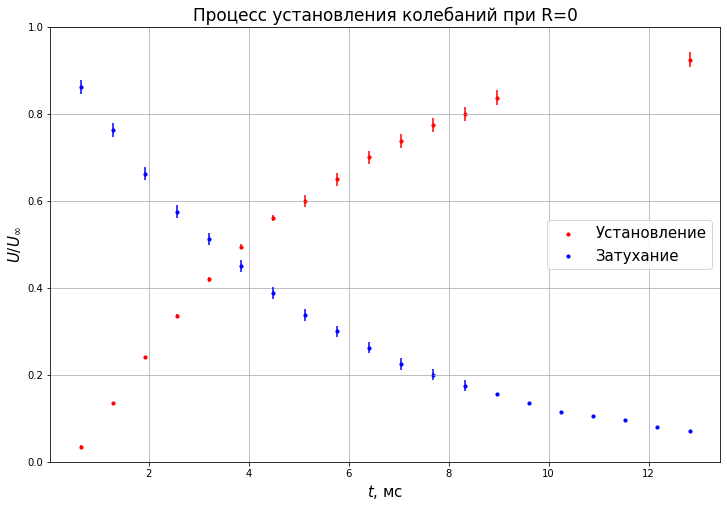

In [26]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"Процесс установления колебаний при R=0", fontsize=17)
plt.xlabel(r"$t$, мс", fontsize=15)
plt.ylabel(r"$U/U_{\infty}$", fontsize=15)
plt.ylim(0, 1)
plt.scatter(tk, Ukr, c="red", s=10, label="Установление")
plt.errorbar(tk, Ukr, yerr=dUkr, linestyle="", c="red")

plt.scatter(tm, Umr, c="blue", s=10, label="Затухание")
plt.errorbar(tm, Umr, yerr=dUmr, linestyle="", c="blue")

plt.legend(fontsize=15, loc="right")
plt.savefig("../pictures/perexod_R_0.eps")

### Линеаризуем чтобы найти $\gamma$

a: -0.205730 +- 0.0039
b: 0.114606 +- 0.019
Q: 23.82196 +- 0.45532
####################################################################################################
a: -0.206804 +- -0.0014
b: -0.013002 +- -0.0073
Q: 23.69816 +- 0.15641
0.8197530439073242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


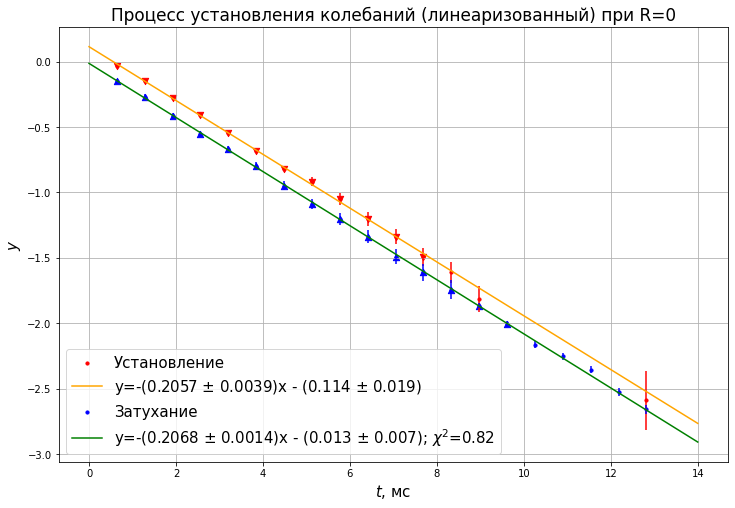

In [27]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"Процесс установления колебаний (линеаризованный) при R=0", fontsize=17)
plt.xlabel(r"$t$, мс", fontsize=15)
plt.ylabel(r"$y$", fontsize=15)

x_mm = np.array([0, 14])

ym = np.log(Umr)
dym = dUmr / Umr

yk = np.log(1 - Ukr)
dyk = dUkr / (1 - Ukr)

slc = slice(None, -3)
plt.scatter(tk, yk, c="red", s=10, label="Установление")
plt.scatter(tk[slc], yk[slc], c="red", s=40, marker="v")
plt.errorbar(tk, yk, yerr=dyk, linestyle="", c="red")
a, b, da, db, f = mnk(tk.to_numpy()[slc], yk.to_numpy()[slc])
plt.plot(x_mm, f(x_mm), label="y=-(0.2057 $\pm$ 0.0039)x - (0.114 $\pm$ 0.019)", color="orange")
print(f"a: {a:5f} +- {da:.2}")
print(f"b: {b:5f} +- {db:.2}")
Q = np.pi * f_0 / np.abs(1000*a)
dQ = Q * np.abs(da/a)
print(f"Q: {Q:.5f} +- {dQ:.5f}")

print("#"*100)

slc = slice(None, -5)
plt.scatter(tm, ym, c="blue", s=10, label="Затухание")
plt.scatter(tm[slc], ym[slc], c="blue", s=40, marker="^")
plt.errorbar(tm, ym, yerr=dym, linestyle="", c="blue")
a, b, da, db, f, chi_min = chi_fit(tm.to_numpy()[slc], ym.to_numpy()[slc], dym.to_numpy()[slc])
plt.plot(x_mm, f(x_mm), label="y=-(0.2068 $\pm$ 0.0014)x - (0.013 $\pm$ 0.007); $\chi^2$=0.82", color="green")
print(f"a: {a:5f} +- {da:.2}")
print(f"b: {b:5f} +- {db:.2}")
Q = np.pi * f_0 / np.abs(1000*a)
dQ = Q * np.abs(da/a)
print(f"Q: {Q:.5f} +- {dQ:.5f}")
print(chi_min)

plt.legend(fontsize=15, loc="lower left")
plt.savefig("../pictures/R_0_damp.eps")

## R = 100 $\Omega$

In [28]:
data = pd.read_csv("perexod_R_100.csv")
f_0 = 1560

tk = 1000 * data.loc[1:, "k"].dropna() / f_0 # ms
Ukr = data.loc[1:, "Uk"].dropna() / data.loc[0, "Uk"]
dUkr = Ukr * np.sqrt((data.loc[1:, "dUk"].dropna() / data.loc[1:, "Uk"].dropna())**2 + (data.loc[0, "dUk"] / data.loc[0, "Uk"])**2)

tm = 1000 * data.loc[1:, "m"].dropna() / f_0 # ms
Umr = data.loc[1:, "Um"].dropna() / data.loc[0, "Um"]
dUmr = Umr * np.sqrt((data.loc[1:, "dUm"].dropna() / data.loc[1:, "Um"].dropna())**2 + (data.loc[0, "dUm"] / data.loc[0, "Um"])**2)

data

,k,Uk,dUk,m,Um,dUm
0,0,4.72,0.04,0.0,4.720,0.04
1,1,0.48,0.04,1.0,2.880,0.04
2,2,1.84,0.04,2.0,1.800,0.04
3,3,2.88,0.04,3.0,1.120,0.04
4,4,3.56,0.04,4.0,0.720,0.04
5,5,3.96,0.04,5.0,0.440,0.04
6,6,4.24,0.04,6.0,0.320,0.04
7,7,4.40,0.04,7.0,0.176,0.04
8,8,4.48,0.04,NaN,NaN,NaN
9,9,4.64,0.04,NaN,NaN,NaN


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


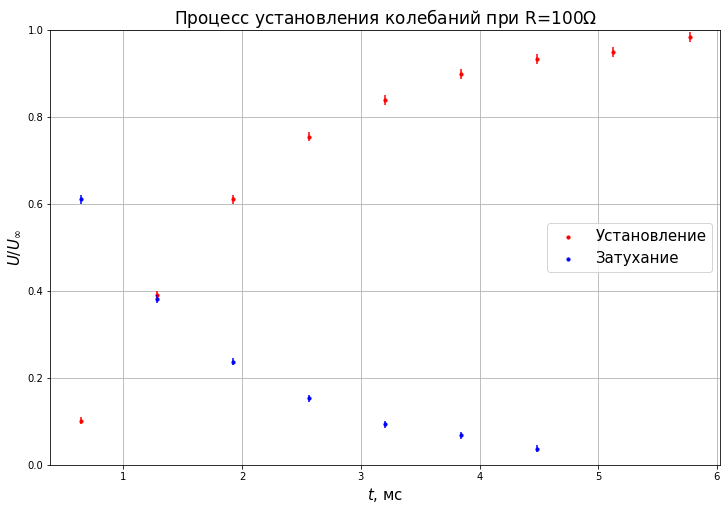

In [29]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"Процесс установления колебаний при R=100$\Omega$", fontsize=17)
plt.xlabel(r"$t$, мс", fontsize=15)
plt.ylabel(r"$U/U_{\infty}$", fontsize=15)
plt.ylim(0, 1)
plt.scatter(tk, Ukr, c="red", s=10, label="Установление")
plt.errorbar(tk, Ukr, yerr=dUkr, linestyle="", c="red")

plt.scatter(tm, Umr, c="blue", s=10, label="Затухание")
plt.errorbar(tm, Umr, yerr=dUmr, linestyle="", c="blue")

plt.legend(fontsize=15, loc="right")
plt.savefig("../pictures/perexod_R_100.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


a: -0.720634 +- 0.073
b: 0.442342 +- 0.26
Q: 6.80080 +- 0.68601
####################################################################################################
a: -0.721994 +- -0.0092
b: -0.034464 +- -0.012
Q: 6.78799 +- 0.08689
1.2505877970788113


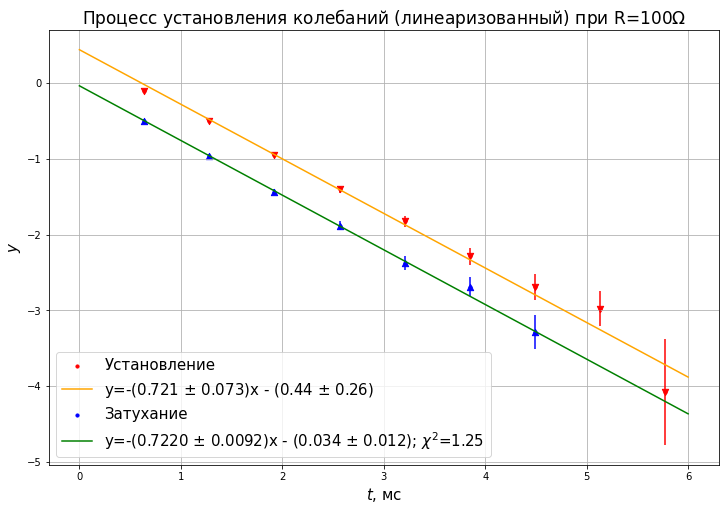

In [33]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"Процесс установления колебаний (линеаризованный) при R=100$\Omega$", fontsize=17)
plt.xlabel(r"$t$, мс", fontsize=15)
plt.ylabel(r"$y$", fontsize=15)

x_mm = np.array([0, 6])

ym = np.log(Umr)
dym = dUmr / Umr

yk = np.log(1 - Ukr)
dyk = dUkr / (1 - Ukr)

slc = slice(None, None)
plt.scatter(tk, yk, c="red", s=10, label="Установление")
plt.scatter(tk[slc], yk[slc], c="red", s=40, marker="v")
plt.errorbar(tk, yk, yerr=dyk, linestyle="", c="red")
a, b, da, db, f = mnk(tk.to_numpy()[slc], yk.to_numpy()[slc])
plt.plot(x_mm, f(x_mm), label="y=-(0.721 $\pm$ 0.073)x - (0.44 $\pm$ 0.26)", color="orange")
print(f"a: {a:5f} +- {da:.2}")
print(f"b: {b:5f} +- {db:.2}")
Q = np.pi * f_0 / np.abs(1000*a)
dQ = Q * np.abs(da/a)
print(f"Q: {Q:.5f} +- {dQ:.5f}")


print("#"*100)

slc = slice(None, None)
plt.scatter(tm, ym, c="blue", s=10, label="Затухание")
plt.scatter(tm[slc], ym[slc], c="blue", s=40, marker="^")
plt.errorbar(tm, ym, yerr=dym, linestyle="", c="blue")
a, b, da, db, f, chi_min = chi_fit(tm.to_numpy()[slc], ym.to_numpy()[slc], dym.to_numpy()[slc])
plt.plot(x_mm, f(x_mm), label="y=-(0.7220 $\pm$ 0.0092)x - (0.034 $\pm$ 0.012); $\chi^2$=1.25", color="green")
print(f"a: {a:5f} +- {da:.2}")
print(f"b: {b:5f} +- {db:.2}")
Q = np.pi * f_0 / np.abs(1000*a)
dQ = Q * np.abs(da/a)
print(f"Q: {Q:.5f} +- {dQ:.5f}")
print(chi_min)

plt.legend(fontsize=15, loc="lower left")
plt.savefig("../pictures/R_100_damp.eps")